In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

In [2]:
loaded_model = tf.saved_model.load("../models/1/")

In [3]:
keras_model = loaded_model.signatures["serving_default"]

In [4]:
if hasattr(loaded_model, 'keras_model'):  # Check if it has a Keras model
    keras_model = loaded_model.keras_model
    keras_model.save("model.h5")
else:
    print("This SavedModel might not have originated from a Keras model.")

This SavedModel might not have originated from a Keras model.


In [5]:
from PIL import Image
import numpy as np

img = Image.open("test.jpg")

img = np.array(img)
img = tf.convert_to_tensor(img)
img = tf.expand_dims(img, axis=0)
img = tf.cast(img, tf.float32) 

In [6]:
predictions = keras_model(img)

In [7]:
np.argmax(predictions['dense_9'][0])

0

In [8]:
tf.saved_model.save(loaded_model, "saved_model_copy")

INFO:tensorflow:Assets written to: saved_model_copy\assets


INFO:tensorflow:Assets written to: saved_model_copy\assets


In [9]:
loaded_model = tf.saved_model.load("saved_model_copy/")

In [10]:
if hasattr(loaded_model, 'keras_model'):  # Check if it has a Keras model
    keras_model = loaded_model.keras_model
    print("Keras model found!")
else:
    print("This SavedModel might not have originated from a Keras model.")

This SavedModel might not have originated from a Keras model.


In [11]:
tf.version.VERSION

'2.16.1'

In [12]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 20

In [13]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "../PlantVillage",
    shuffle= True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [14]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [15]:
len(dataset), 68*32

(68, 2176)

In [16]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())
    # print(image_batch[0])

(32, 256, 256, 3)
[1 0 0 1 1 2 1 0 1 1 2 0 0 1 0 1 0 0 0 0 1 2 1 2 1 0 1 0 1 1 1 0]


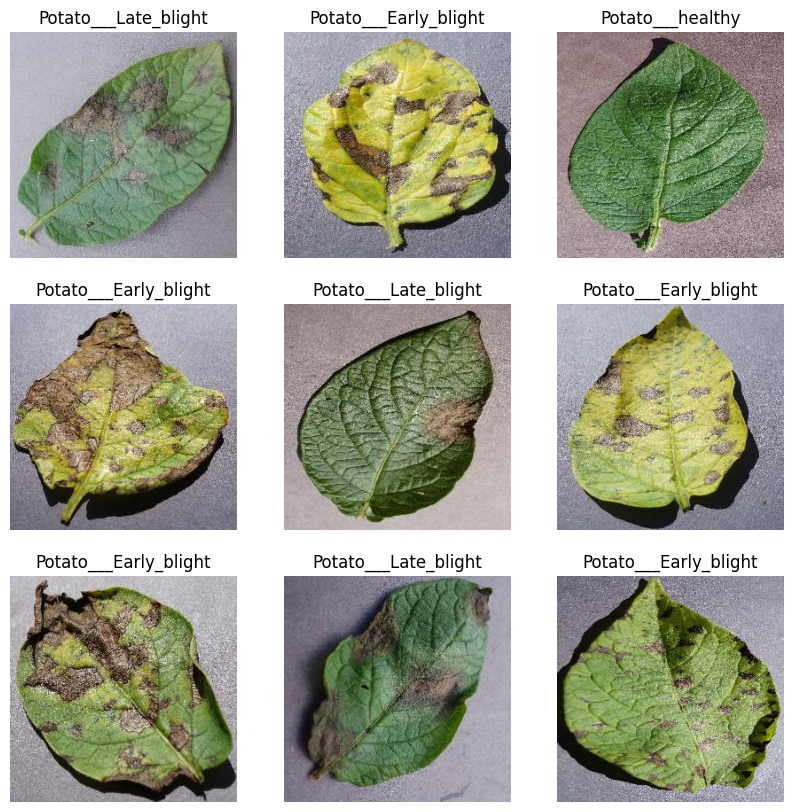

In [17]:
for image_batch, labels_batch in dataset.take(1):
    plt.figure(figsize=(10,10))
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [18]:
train_size = 0.8
train_size = int(train_size * 68)
train_size

54

In [19]:
train_ds = dataset.take(train_size)
test_ds = dataset.skip(train_size)
val_ds = test_ds.take(6)
test_ds = test_ds.skip(6)
len(train_ds), len(val_ds), len(test_ds)    

(54, 6, 8)

In [20]:
def get_dataset_partititon(dataset, train_split=0.8, val_split=0.1, test_size=0.1, shuffle = True, shuffle_size=10000):
    
    dataset_size = len(dataset)
    
    if shuffle:
        dataset = dataset.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * dataset_size)
    val_size = int(val_split * dataset_size)
    
    train_ds = dataset.take(train_size)
    
    val_ds = dataset.skip(train_size).take(val_size)
    test_ds = dataset.skip(train_size + val_size)
    
    return train_ds, val_ds, test_ds

In [21]:
train_ds, val_ds, test_ds = get_dataset_partititon(dataset)

In [22]:
len(train_ds), len(val_ds), len(test_ds)

(54, 6, 8)

### Data Preprocessing

In [23]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [24]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255),
])

AttributeError: module 'keras._tf_keras.keras.layers' has no attribute 'experimental'

: 

In [ ]:
data_augementation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

### Model

In [55]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augementation,
    
    layers.Conv2D(32, (3,3), activation="relu", input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    
    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dense(n_classes, activation="softmax")
])

model.build(input_shape=input_shape)

In [52]:
input_shape

(32, 256, 256, 3)

In [56]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_5 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 sequential_6 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d_16 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 127, 127, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 62, 62, 64)       0         
 g2D)                                                 

In [57]:
model.compile(
    optimizer="adam",
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

In [60]:
history = model.fit(
    train_ds,
    epochs=20,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/20


54/54 [==============================] - 46s 853ms/step - loss: 0.3881 - accuracy: 0.8466 - val_loss: 0.3446 - val_accuracy: 0.8281
Epoch 2/20
54/54 [==============================] - 45s 839ms/step - loss: 0.2868 - accuracy: 0.8889 - val_loss: 0.2432 - val_accuracy: 0.9167
Epoch 3/20
54/54 [==============================] - 45s 832ms/step - loss: 0.2559 - accuracy: 0.9086 - val_loss: 0.1953 - val_accuracy: 0.9115
Epoch 4/20
54/54 [==============================] - 46s 844ms/step - loss: 0.2455 - accuracy: 0.9051 - val_loss: 0.3973 - val_accuracy: 0.8438
Epoch 5/20
54/54 [==============================] - 43s 802ms/step - loss: 0.1862 - accuracy: 0.9265 - val_loss: 0.1146 - val_accuracy: 0.9375
Epoch 6/20
54/54 [==============================] - 44s 809ms/step - loss: 0.1699 - accuracy: 0.9300 - val_loss: 0.2726 - val_accuracy: 0.8854
Epoch 7/20
54/54 [==============================] - 44s 805ms/step - loss: 0.1529 - accuracy: 0.9433 - val_loss: 0.2462 - val_accuracy: 0.9115
Epoch 8/20

In [66]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 2s 237ms/step - loss: 0.0237 - accuracy: 0.9922


In [67]:
history

In [68]:
history.params, history.history.keys(), 

({'verbose': 1, 'epochs': 20, 'steps': 54},
 dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy']))

In [69]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

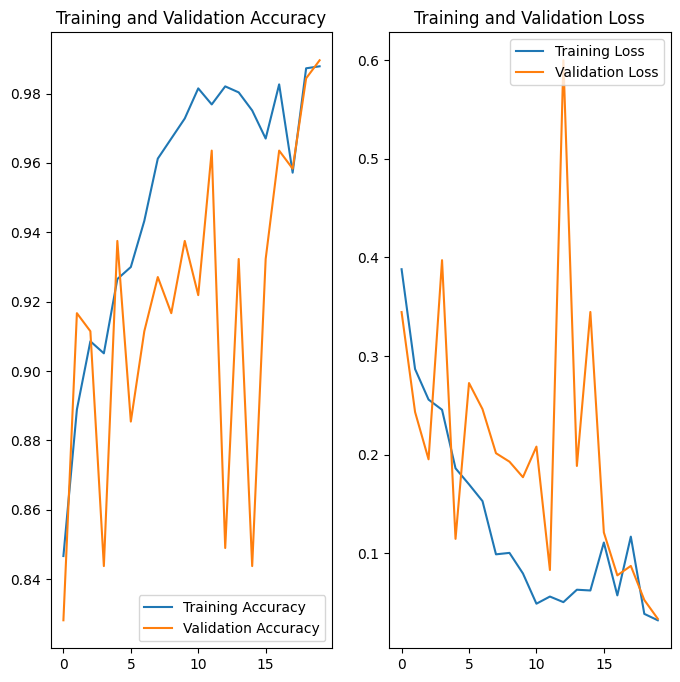

In [70]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(acc, label="Training Accuracy")
plt.plot(val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label="Training Loss")
plt.plot(range(EPOCHS), val_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")
plt.show()

First Image
Actual Label: Potato___Early_blight
1/1 [==============================] - 0s 309ms/step
Predicted Label: Potato___Early_blight


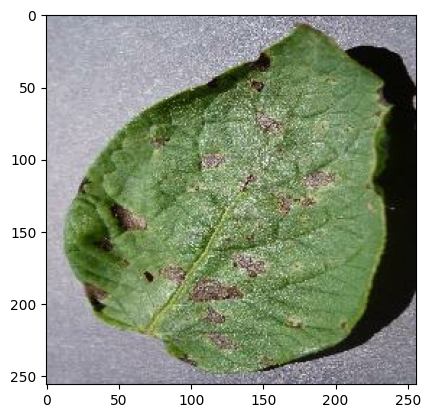

In [73]:
for images_batch, labels_batch in test_ds.take(1):
    
    first_img = images_batch[0].numpy().astype("uint8")
    first_label = labels_batch[0].numpy()
    
    print("First Image")
    plt.imshow(first_img)
    print(f"Actual Label: {class_names[first_label]}")
    
    batch_pred = model.predict(images_batch)
    print(f"Predicted Label: {class_names[np.argmax(batch_pred[0])]}")

In [76]:
def predict(mode, img):
    img_arr = tf.keras.preprocessing.image.img_to_array(img.numpy())
    img_arr = tf.expand_dims(img_arr, 0) # create a batch 
    
    predictions = model.predict(img_arr)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    
    return predicted_class, confidence

1/1 [==============================] - 0s 40ms/step


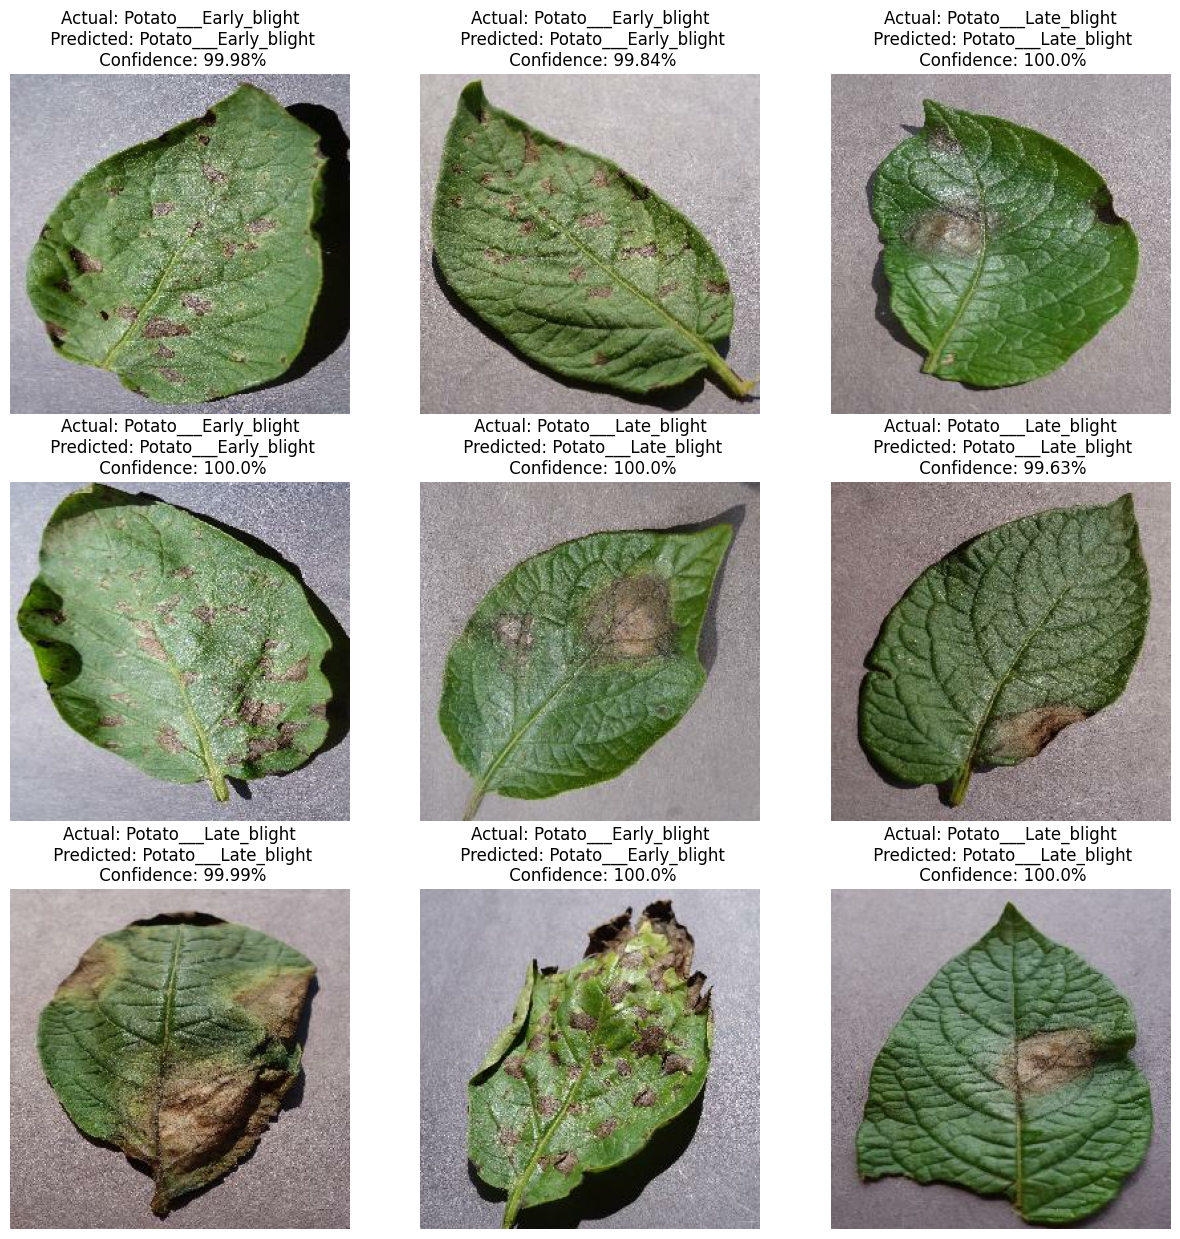

In [81]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")
        
        predicted_class, confidence = predict(model, images[i])
        actual_class = class_names[labels[i]]
        plt.title(f"Actual: {actual_class}\n Predicted: {predicted_class}\n Confidence: {confidence}%")

In [86]:
import os
model_version = max([int(i) for i in os.listdir("../models")])+1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/3\assets


INFO:tensorflow:Assets written to: ../models/3\assets


3